In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
# import warnings
# warnings.filterwarnings("ignore")

import jax
from jax import lax, jit, vmap, value_and_grad
import jax.random as jr
import jax.numpy as jnp
import jax.scipy.stats as jstats
import pandas as pd
import numpy as np
from tinygp import GaussianProcess, kernels, transforms
import optax
import equinox as eqx
import numpy as np
import scipy.stats.qmc as qmc
from functools import partial
from typing import NamedTuple, Callable, Optional
from jaxtyping import Float, Array

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0);

# Multifidelity Gaussian process surrogates

## Example 1: Multi-fidelity regression of a synthetic function

Suppose we have a ***high***-fidelity model $f_h$ and a ***low***-fidelity model $f_\ell$ of some phemonenon, given by

$$
\begin{align*}
    f_h(x) &= \frac{1}{2} \sin\left( \frac{5}{2} x_1 + \frac{2}{3} x_2 \right)^2 + \frac{2}{3} e^{-x_1 (x_2 - \frac{1}{2})^2} \cos(4x_1 + x_2)^2 \\
    f_\ell(x) &= 1.5 f_h(x) + \frac{1}{3} \sin(x_1 + x_2) + \frac{1}{2} e^{-x_1} \sin(x_1 + 7x_2).
\end{align*}
$$

(These function definitions are modified from [Perdikaris et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/).)

We want to create a surrogate for $f_h$.

### Low-fidelity GP

Suppose we have some low fidelity data $(\mathbf{X}_\ell, \mathbf{y}_\ell)$ and some high fidelity data $(\mathbf{X}_h, \mathbf{y}_h)$.
<!-- 
$$
f_h|f_l \sim \operatorname{GP}(m_h, k_{h|f_l}),
$$

where the mean function is a standard user choice, e.g., a constant, a linear function, or a polynomial,
but the covariance function is now:

$$
k_h(x, x') = k((x, f_l(x)), (x', f_l(x'))),
$$

$$
f_l \approx \tilde{m}_l(x),
$$

and then take our kernel to be:

$$
k_h(x, x') = k((x, \tilde{m}_l(x)), (x', \tilde{m}_l(x'))).
$$ -->
<!-- 
Suppose we evaluate $f_h$ at a limited number of points $x_h$:

$$
\begin{align*}
    \mathbf{X}_h &\equiv \begin{bmatrix} x_{h,1} \\ \vdots \\ x_{h,N_h} \end{bmatrix} &\in \mathbb{R}^{N_h \times d} \\
    \mathbf{y}_h &\equiv \begin{bmatrix} y_{h,1} \\ \vdots \\ y_{h,N_h} \end{bmatrix} 
    \equiv \begin{bmatrix} f_h(x_{h,1}) \\ \vdots \\ f_h(x_{h,N_h}) \end{bmatrix} &\in \mathbb{R}^{N_h}
\end{align*}
$$

where $N_h$ is the number of evaluations, $d$ is the input dimension, and $x_{h,i} \in \mathbb{R}^d$ and $y_{h,i} \in \mathbb{R}$ are the input and output for the $i^\text{th}$ evaluation, respectively. 
This is our high-fidelity data.

Suppose we also evaluate $f_\ell$ at the same points $x_h$ ***and*** at some different points $x_\ell' \in \mathbb{R}^{N_\ell' \times d}$:

$$
\begin{align*}
    \mathbf{y}^{\text{same}}_\ell &\equiv \begin{bmatrix} f_\ell(x_{h,1}) \\ \vdots \\ f_\ell(x_{h,N_h}) \end{bmatrix} &\in \mathbb{R}^{N_h} \\
    \mathbf{y}^{\text{diff}}_\ell &\equiv \begin{bmatrix} f_\ell(x_{\ell,1}) \\ \vdots \\ f_\ell(x_{\ell,N_\ell'}) \end{bmatrix} &\in \mathbb{R}^{N_\ell'}
\end{align*}
$$

This is our low fidelity data.
Let's generate the data and visualize the functions. -->

In [2]:
def high_fidelity_model(x):
    x1, x2 = x[0], x[1]
    return 1/2*jnp.sin(5/2*x1 + 2/3*x2)**2 + 2/3*jnp.exp(-x1*(x2 - 0.5)**2)*jnp.cos(4*x1 + x2)**2

def low_fidelity_model(x):
    x1, x2 = x[0], x[1]
    return 2.5*high_fidelity_model(x) + 1/3*( jnp.sin(x1 + x2) + 1/2*jnp.exp(-x1)*jnp.sin(x1 + 7*x2) )

def generate_synthetic_data(n_l, n_h, n_test, key=None):
    """Returns datasets necessary for training and testing a multi-fidelity GP."""

    # Train data
    X_train_l = jnp.array(qmc.LatinHypercube(2).random(n_l))
    X_train_h = jnp.array(qmc.LatinHypercube(2).random(n_h))
    y_train_l = vmap(low_fidelity_model)(X_train_l)
    y_train_h = vmap(high_fidelity_model)(X_train_h)

    # Test data
    X_test = jr.uniform(key, (n_test, 2))
    y_test_l = vmap(low_fidelity_model)(X_test)
    y_test_h = vmap(high_fidelity_model)(X_test)

    return X_train_l, X_train_h, X_test, y_train_l, y_train_h, y_test_l, y_test_h

In [3]:
N_LOW_FIDELITY = 50
N_HIGH_FIDELITY = 8
N_TEST = 100

key, subkey = jr.split(key)
X_train_l, X_train_h, X_test, y_train_l, y_train_h, y_test_l, y_test_h = generate_synthetic_data(N_LOW_FIDELITY, N_HIGH_FIDELITY, N_TEST, key=subkey)

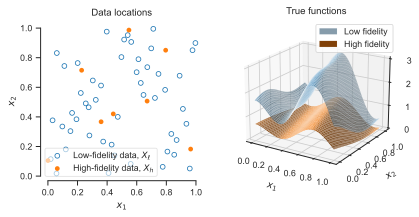

In [4]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(X_train_l[:,0], X_train_l[:, 1], label=r'Low-fidelity data, $X_\ell$', marker='o', facecolors='none', edgecolors='tab:blue')
ax.scatter(X_train_h[:,0], X_train_h[:, 1], label=r'High-fidelity data, $X_h$', marker='o', facecolors='tab:orange', edgecolors='none')
ax.set_aspect('equal')
ax.set_title('Data locations')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
leg = ax.legend()
leg.get_frame().set_alpha(0.6)

x1, x2 = jnp.linspace(0, 1, 100), jnp.linspace(0, 1, 100)
X1, X2 = jnp.meshgrid(x1, x2)
Y_low = vmap(low_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)
Y_high = vmap(high_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X1, X2, Y_low, label='Low fidelity', lw=0.1, alpha=0.5)
ax.plot_surface(X1, X2, Y_high, label='High fidelity', lw=0.1)
ax.view_init(elev=20, azim=-58)
ax.set_title('True functions')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend()
sns.despine(trim=True);

We'll start by fitting a Gaussian process to the low fidelity data:

In [5]:
def build_gp(params, X):
    """Build a Gaussian process with RBF kernel.
    
    Parameters
    ----------
    params : dict
        Hyperparameters of the GP.
    X : ndarray
        Training data.
    
    Returns
    -------
    GaussianProcess
        The GP.
    """
    sigma = 1e-3  # Fixing the measurement noise
    amp = jnp.exp(params['log_amplitude'])
    ell = jnp.exp(params['log_lengthscales'])
    k = amp*transforms.Linear(1/ell, kernels.ExpSquared())  # Must be constructed this way if ell is a vector
    return GaussianProcess(k, X, diag=sigma**2)

def eval_gp(build_gp, Xq, X, y, params):
    """Evaluate a GP at query points Xq.
    
    Parameters
    ----------
    build_gp : callable
        A function that builds a GP from the hyperparameters.
    Xq : ndarray
        Query points.
    X, y: ndarray
        Training data.
    params : dict
        Hyperparameters of the GP.
    
    Returns
    -------
    GaussianProcess
        The conditioned GP.
    """
    gp = build_gp(params, X)
    _, cond_gp = gp.condition(y, Xq)
    return cond_gp

def loss(build_gp, params, X, y):
    """Negative marginal log likelihood of the GP."""
    gp = build_gp(params, X)
    return -gp.log_probability(y)

@eqx.filter_jit
def train_step_adam(carry, _, build_gp, X, y, optim, batch_size):
    params, opt_state, key = carry
    key, subkey = jr.split(key)
    idx = jr.randint(subkey, (batch_size,), 0, X.shape[0])
    value, grads = value_and_grad(partial(loss, build_gp))(params, X[idx], y[idx])
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, key), value

def train_gp(build_gp, init_params, X, y, num_iters, learning_rate, batch_size, key):
    """Optimize the hyperparameters (xi) of a GP using the Adam optimizer.
    
    Parameters
    ----------
    init_params : dict
        Initial values of the hyperparameters.
    X, y: ndarray
        Training data.
    num_iters : int
        Number of optimization steps.
    learning_rate : float
        Learning rate for the optimizer.
    
    Returns
    -------
    dict
        The optimized hyperparameters.
    ndarray
        The loss values at each iteration.
    """
    
    # Initialize the optimizer
    optim = optax.adam(learning_rate)

    # Initialize the optimizer state
    init_carry = (init_params, optim.init(init_params), key)

    # Do optimization
    train_step = partial(train_step_adam, build_gp=build_gp, X=X, y=y, optim=optim, batch_size=batch_size)
    carry, losses = lax.scan(train_step, init_carry, None, num_iters)

    return carry[0], losses  # (optimized params, loss values)

In [6]:
params_l = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0]))
}

key, subkey = jr.split(key)
params_l, losses_l = train_gp(
    build_gp=build_gp, 
    init_params=params_l, 
    X=X_train_l, 
    y=y_train_l, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=10,
    key=subkey
)

Let's visualize the low-fidelity data and the function $f_\ell$.

In [7]:
X1, X2 = jnp.meshgrid(jnp.linspace(0, 1, 50), jnp.linspace(0, 1, 50))
Xq_plt = jnp.stack([X1.ravel(), X2.ravel()], axis=1)

cond_gp_plt = eval_gp(build_gp, Xq_plt, X_train_l, y_train_l, params_l)
Y_mean = cond_gp_plt.mean.reshape(*X1.shape)

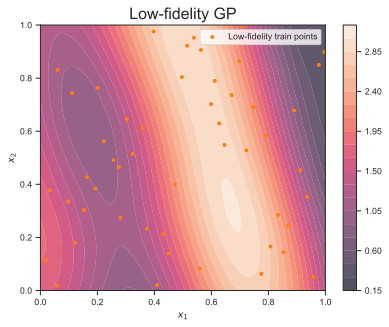

In [8]:
fig, ax = plt.subplots()
p = ax.contourf(X1, X2, Y_mean, levels=20, alpha=0.7)
fig.colorbar(p)
ax.scatter(X_train_l[:, 0], X_train_l[:, 1], 10, label="Low-fidelity train points", color='tab:orange')
ax.set_title('Low-fidelity GP', fontsize=16)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend();

Let's check the fit of the low-fidelity GP to the low-fidelity data with a pairplot.

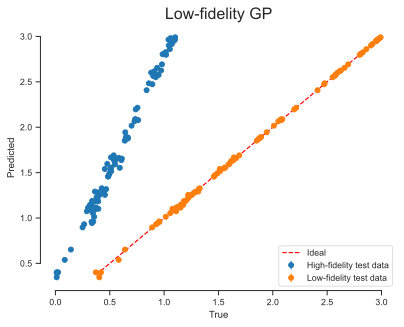

In [9]:
cond_gp = eval_gp(build_gp, X_test, X_train_l, y_train_l, params_l)
y_pred_l = cond_gp.mean
y_std_l = jnp.sqrt(cond_gp.variance)

fig, ax = plt.subplots()
ax.errorbar(y_test_h, y_pred_l, yerr=2 * y_std_l, fmt="o", markersize=5, lw=1, label='High-fidelity test data')
ax.errorbar(y_test_l, y_pred_l, yerr=2 * y_std_l, fmt="o", markersize=5, lw=1, label='Low-fidelity test data')
ax.plot([y_test_l.min(), y_test_l.max()], [y_test_l.min(), y_test_l.max()], 'r--', label='Ideal')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('Low-fidelity GP', fontsize=16)
ax.legend()
sns.despine(trim=True);

As expected, the low-fidelity GP matches the low-fidelity function $f_\ell$ well, but it completely misses the high-fidelity function $f_h$.

### Multi-fidelity GP

For the multi-fidelity GP, we'll use the kernel

$$
k_h(x, x') = k\Big(\big(x, \tilde{m}_l(x)\big), \big(x', \tilde{m}_l(x')\big)\Big).
$$

where $\tilde{m}_l$ is the mean of the low-fidelity GP.
In `tinygp`, this is best implemented with a `tinygp.transforms.Transform` object as below:

In [10]:
def generate_build_multi_fidelity_gp(build_gp, X_train_l, y_train_l, params_l):
    """Factory function for creating multi-fidelity GP builders."""

    def build_multi_fidelity_gp(params, X):
        """Build a multi-fidelity Gaussian process with RBF kernel."""
        sigma = 1e-3  # Fixing the measurement noise
        amp = jnp.exp(params['log_amplitude'])
        ell = jnp.exp(params['log_lengthscales'])
        ell_aug = jnp.exp(params['log_lengthscale_l'])  # Lengthscale for the low-fidelity GP mean

        # This is the mean, m_l, of the low-fidelity GP.
        # It is wrapped so that one simply needs to pass in a single input x vector.
        # It is also jitted.
        eval_low_fidelity_gp_mean = jit(lambda x: partial(eval_gp, build_gp)(x[None], X_train_l, y_train_l, params_l).mean)
        
        # This is the function that lifts the input x from e.g., 2 dimensions to 3 dimensions, 
        # where the 3rd dimension represents the low-fidelity GP mean.
        # It also applies the length scaling.
        lift_and_scale = lambda x: jnp.hstack([x/ell, eval_low_fidelity_gp_mean(x)/ell_aug])

        # The kernel is constructed in the lifted input space via a Transform.
        # The way Transform works is that for some transformation T, Transform(T, k1) produces
        # the kernel k(x, x') = k1(T(x), T(x')).
        k = amp*transforms.Transform(lift_and_scale, kernels.ExpSquared())

        return GaussianProcess(k, X, diag=sigma**2)
    
    return build_multi_fidelity_gp

Here's how we can train the multi-fidelity GP:

In [11]:
params_m = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0])),
    'log_lengthscale_l': jnp.log(1.0)
}

build_multi_fidelity_gp = generate_build_multi_fidelity_gp(build_gp, X_train_l, y_train_l, params_l)

params_m, losses_m = train_gp(
    build_gp=build_multi_fidelity_gp,
    init_params=params_m, 
    X=X_train_h, 
    y=y_train_h, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=5,
    key=subkey
)

This is what the multi-fidelity GP looks like:

In [12]:
X1, X2 = jnp.meshgrid(jnp.linspace(0, 1, 50), jnp.linspace(0, 1, 50))
Xq_plt = jnp.stack([X1.ravel(), X2.ravel()], axis=1)

cond_gp_plt = eval_gp(build_multi_fidelity_gp, Xq_plt, X_train_h, y_train_h, params_m)
Y_mean = cond_gp_plt.mean.reshape(*X1.shape)

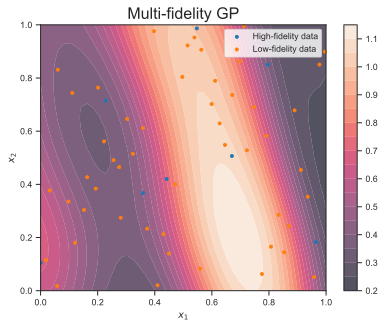

In [13]:
fig, ax = plt.subplots()
p = ax.contourf(X1, X2, Y_mean, levels=20, alpha=0.7)
fig.colorbar(p)
ax.scatter(X_train_h[:, 0], X_train_h[:, 1], 10, label="High-fidelity data")
ax.scatter(X_train_l[:, 0], X_train_l[:, 1], 10, label="Low-fidelity data")
ax.set_title('Multi-fidelity GP', fontsize=16)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend();

Let's compare the accuracy of the multi-fidelity GP to that of a GP fit only to the high fidelity data.

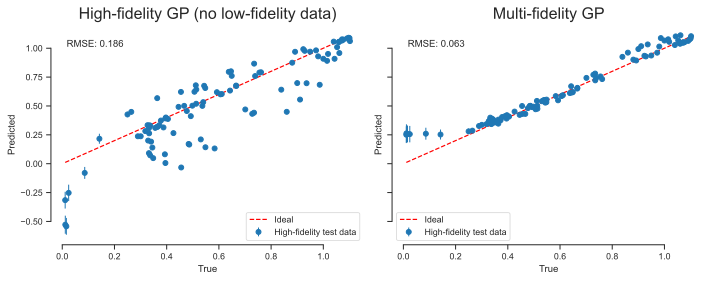

In [14]:
params_h = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0]))
}

key, subkey = jr.split(key)
params_h, losses_h = train_gp(
    build_gp=build_gp, 
    init_params=params_h, 
    X=X_train_h, 
    y=y_train_h, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=10,
    key=subkey
)

rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

cond_gp = eval_gp(build_multi_fidelity_gp, X_test, X_train_h, y_train_h, params_m)
y_pred_m = cond_gp.mean
y_std_m = jnp.sqrt(cond_gp.variance)

cond_gp = eval_gp(build_gp, X_test, X_train_h, y_train_h, params_h)
y_pred_h = cond_gp.mean
y_std_h = jnp.sqrt(cond_gp.variance)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True, sharex=True, sharey=True)

axes[0].errorbar(y_test_h, y_pred_h, yerr=2 * y_std_m, fmt="o", markersize=5, lw=1, label='High-fidelity test data')
axes[0].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', label='Ideal')
axes[0].annotate(f"RMSE: {rmse(y_test_h, y_pred_h):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
axes[0].set_xlabel('True')
axes[0].set_ylabel('Predicted')
axes[0].set_title('High-fidelity GP (no low-fidelity data)', fontsize=16)
axes[0].legend()
sns.despine(trim=True);

axes[1].errorbar(y_test_h, y_pred_m, yerr=2 * y_std_m, fmt="o", markersize=5, lw=1, label='High-fidelity test data')
axes[1].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', label='Ideal')
axes[1].annotate(f"RMSE: {rmse(y_test_h, y_pred_m):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
axes[1].set_xlabel('True')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Multi-fidelity GP', fontsize=16)
axes[1].legend()
sns.despine(trim=True);

The multi-fidelity GP has the most accurate predictions. Let's visualize the mean predictive surface against the ground truth:

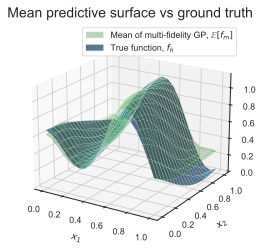

In [15]:
# Surface plot
x1, x2 = jnp.linspace(0, 1, 20), jnp.linspace(0, 1, 20)
X1, X2 = jnp.meshgrid(x1, x2)
X_plt = jnp.stack([X1.ravel(), X2.ravel()], axis=-1)
Y_high_plt = vmap(high_fidelity_model)(X_plt).reshape(X1.shape)
num_samples = 20
cond_gp = eval_gp(build_multi_fidelity_gp, X_plt, X_train_h, y_train_h, params_m)
# mean_multi_plt = sample_multi_fidelity_gp(X_plt, key, num_samples).mean(axis=0).reshape(X1.shape)
mean_multi_plt = cond_gp.mean.reshape(X1.shape)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, mean_multi_plt, label=r'Mean of multi-fidelity GP, $\mathbb{E}[f_m]$', color='tab:green', lw=0.1, alpha=0.3)
ax.plot_surface(X1, X2, Y_high_plt, label=r'True function, $f_h$', color='tab:blue', lw=0.1, alpha=0.7)
ax.view_init(elev=20, azim=-58)
ax.set_title('Mean predictive surface vs ground truth', fontsize=14)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend();

The multi-fidelity GP $\hat{f}_m$ approximates the high-fidelity model $f_h$ fairly well! This is a significant improvement over naively fitting to the high-fidelity data alone.

### Questions

- Decrease `N_LOW_FIDELITY`. How does the multi-fidelity GP $\hat{f}_m$ perform with less low-fidelity data?
- Decrease `N_HIGH_FIDELITY`. How does multi-fidelity GP $\hat{f}_m$ perform with less high-fidelity data?
- Increase `N_HIGH_FIDELITY`. At what point is the high-fidelity-only GP $\hat{f}_h$ just as good as the multi-fidelity GP $\hat{f}_m$?
- Add more terms (sin/cos, exponential, quadratic, or whetever you want) to `low_fidelity_model`. How different can the low-fidelity model $f_\ell$ be from the high-fidelity model $f_h$ and still get a good surrogate $\hat{f}_m$?

## Example 2: Stochastic incompressible flow past a cylinder

This example is taken from [Perdikaris et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/). Suppose you have a flow past a cylinder, subject to random inflow boundary conditions of the form

$$
U_\infty(x) = 1 + \sigma_1 \sin\left(\frac{\pi y}{9}\right) + \sigma_2 \left[\xi_1 \sin\left(\frac{\pi y}{9}\right) + \xi_2 \cos\left( \frac{\pi y}{9} \right) \right] \quad \xi_1, \xi_2 \sim \mathcal{N}(0, 1),
$$

Let $C_\text{BP}$ be the base pressure coefficient at the rear of the cylinder (see figure below, figure 9 from [Perdikaris et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/)).

<img src="https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/wesley/book/images/flow-past-cylinder.jpg" alt="flow-past-cylinder" width="600"/>

The quantity of interest is the mean of the upper 40% distribution for $C_\text{BP}$, i.e. the *superquantile risk* $f(x) \equiv \mathcal{R}_{0.6}[C_\text{BP}](x)$.
We have two different-fidelity models that compute $f$.
To train the surrogate, we have 8 simulations from the high-fidelity model $f_h$ and 99 simulations from the low-fidelity model $f_\ell$.

Here are the data:

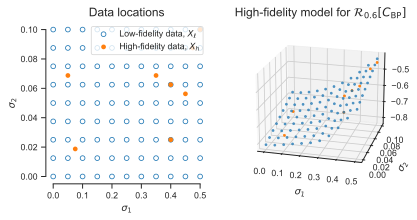

In [ ]:
base_url = 'https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/data/mf_cylinder_flow'
high_fid_data = pd.read_csv(base_url + '/high_fidelity_data.csv')
low_fid_data = pd.read_csv(base_url + '/low_fidelity_data.csv')
ground_truth = pd.read_csv(base_url + '/ground_truth.csv')

Xh_cyl = jnp.array(high_fid_data[['x1', 'x2']].values)
yh_cyl = jnp.array(high_fid_data['y'].values)
Xl_cyl = jnp.array(low_fid_data[['x1', 'x2']].values)
yl_cyl = jnp.array(low_fid_data['y'].values)
gt = ground_truth.values.reshape(21, 17, 3)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(Xl_cyl[:, 0], Xl_cyl[:, 1], label=r'Low-fidelity data, $X_\ell$', marker='o', facecolors='none', edgecolors='tab:blue')
ax.scatter(Xh_cyl[:, 0], Xh_cyl[:, 1], label=r'High-fidelity data, $X_h$', marker='o', facecolors='tab:orange', edgecolors='none')
ax.set_aspect(5)
ax.set_title('Data locations', fontsize=12)
ax.set_xlabel(r'$\sigma_1$')
ax.set_ylabel(r'$\sigma_2$')
leg = ax.legend(loc='upper right')
leg.get_frame()

ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(Xl_cyl[:, 0], Xl_cyl[:, 1], yl_cyl, s=4, label='Low fidelity', color='tab:blue', alpha=0.7)
ax.scatter3D(Xh_cyl[:, 0], Xh_cyl[:, 1], yh_cyl, s=4, label='High fidelity', color='tab:orange', alpha=1)
ax.view_init(elev=20, azim=-75)
ax.set_title(r'High-fidelity model for $\mathcal{R}_{0.6}[C_\text{BP}]$', fontsize=12)
ax.set_xlabel(r'$\sigma_1$')
ax.set_ylabel(r'$\sigma_2$')
sns.despine(trim=True);

### Multi-fidelity Gaussian process for superquantile risk
<!-- for the risk, $\mathcal{R}_{0.6}[C_\text{BP}]$ -->

As before, we first construct the low-fidelity GP surrogate:

In [20]:
params_l_cyl = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0]))
}

key, subkey = jr.split(key)
params_l_cyl, losses_l_cyl = train_gp(
    build_gp=build_gp, 
    init_params=params_l_cyl, 
    X=Xl_cyl, 
    y=yl_cyl, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=10,
    key=subkey
)

Next the multi-fidelity GP surrogate:

In [21]:
params_m_cyl = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0])),
    'log_lengthscale_l': jnp.log(1.0)
}

build_multi_fidelity_gp = generate_build_multi_fidelity_gp(build_gp, Xl_cyl, yl_cyl, params_l_cyl)

params_m_cyl, losses_m_cyl = train_gp(
    build_gp=build_multi_fidelity_gp,
    init_params=params_m_cyl, 
    X=Xh_cyl, 
    y=yh_cyl, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=5,
    key=subkey
)

And let's also construct a surrogate on just the high-fidelity data, for comparison:

In [22]:
params_h_cyl = {
    'log_amplitude': jnp.log(1.0),
    'log_lengthscales': jnp.log(jnp.array([1.0, 1.0]))
}

key, subkey = jr.split(key)
params_h_cyl, losses_h_cyl = train_gp(
    build_gp=build_gp, 
    init_params=params_h_cyl, 
    X=Xh_cyl, 
    y=yh_cyl, 
    num_iters=5000, 
    learning_rate=1e-3,
    batch_size=10,
    key=subkey
)

As before, let's visualize the predictive accuracy with some parity plots:

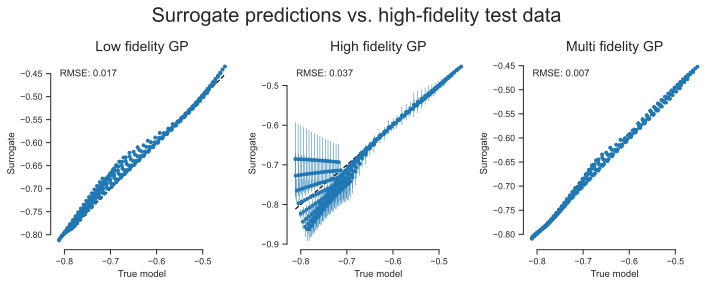

In [23]:
X_test_cyl = ground_truth[['x1', 'x2']].values
y_test_cyl = ground_truth['y'].values

cond_gp = eval_gp(build_gp, X_test_cyl, Xl_cyl, yl_cyl, params_l_cyl)
mean_low_test_cyl = cond_gp.mean
std_low_test_cyl = jnp.sqrt(cond_gp.variance)

cond_gp = eval_gp(build_gp, X_test_cyl, Xh_cyl, yh_cyl, params_h_cyl)
mean_high_test_cyl = cond_gp.mean
std_high_test_cyl = jnp.sqrt(cond_gp.variance)

cond_gp = eval_gp(build_multi_fidelity_gp, X_test_cyl, Xh_cyl, yh_cyl, params_m_cyl)
mean_multi_test_cyl = cond_gp.mean
std_multi_test_cyl = jnp.sqrt(cond_gp.variance)

# Parity plot - add uncertainty on predictions using whiskers
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)
fig.suptitle("Surrogate predictions vs. high-fidelity test data", fontsize=20)
ax[0].errorbar(y_test_cyl, mean_low_test_cyl, yerr=2 * std_low_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[0].plot(y_test_cyl, y_test_cyl, "k--")
ax[0].set_xlabel("True model")
ax[0].set_ylabel("Surrogate")
ax[0].set_title("Low fidelity GP", fontsize=14)
ax[0].annotate(f"RMSE: {rmse(y_test_cyl, mean_low_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[1].errorbar(y_test_cyl, mean_high_test_cyl, yerr=2 * std_high_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[1].plot(y_test_cyl, y_test_cyl, "k--")
ax[1].set_xlabel("True model")
ax[1].set_ylabel("Surrogate")
ax[1].set_title("High fidelity GP", fontsize=14)
ax[1].annotate(f"RMSE: {rmse(y_test_cyl, mean_high_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[2].errorbar(y_test_cyl, mean_multi_test_cyl, yerr=2 * std_multi_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[2].plot(y_test_cyl, y_test_cyl, "k--")
ax[2].set_xlabel("True model")
ax[2].set_ylabel("Surrogate")
ax[2].set_title("Multi fidelity GP", fontsize=14)
ax[2].annotate(f"RMSE: {rmse(y_test_cyl, mean_multi_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

sns.despine(trim=True);

The multi-fidelity GP has the best predictive accuracy. Let's visualize the response surface of the surrogate vs. the true high-fidelity model:

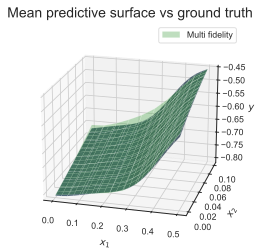

In [24]:
# Surface plot
x1_cyl, x2_cyl = jnp.linspace(ground_truth['x1'].min(), ground_truth['x1'].max(), 10), jnp.linspace(ground_truth['x2'].min(), ground_truth['x2'].max(), 10)
X1_cyl, X2_cyl = jnp.meshgrid(x1_cyl, x2_cyl)
X_plt_cyl = jnp.stack([X1_cyl.ravel(), X2_cyl.ravel()], axis=-1)
# Y_high_plt_cyl = vmap(high_fidelity_model)(X_plt_cyl).reshape(X1_cyl.shape)
num_samples_cyl = 15

key, subkey = jr.split(key)
mean_multi_plt_cyl = eval_gp(build_multi_fidelity_gp, X_plt_cyl, Xh_cyl, yh_cyl, params_m_cyl).mean.reshape(X1_cyl.shape)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gt[:,:,0], gt[:,:,1], gt[:,:,2], lw=0.1, color='tab:blue', alpha=0.7)
ax.plot_surface(X1_cyl, X2_cyl, mean_multi_plt_cyl, label='Multi fidelity', color='tab:green', lw=0.1, alpha=0.3)
ax.view_init(elev=20, azim=-75)
ax.set_title('Mean predictive surface vs ground truth', fontsize=14)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend();

The surfaces are almost right on top of each other.